<a href="https://colab.research.google.com/github/EldenLordx/Yolo_world/blob/main/yolo_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO-World 复现
---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)


YOLO-World 旨在解决现有 zero-shot 目标检测模型的速度局限性。其他最先进的模型使用的Transformers架构功能强大但通常速度较慢，而YOLO-World使用的是基于CNN的快速YOLO架构。

根据这篇论文，YOLO-World的大模型版本达到了35.4 AP, 52.0 FPS，小模型版本达到了26.2 AP, 74.1 FPS，这在当时是非常夸张的数据。

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## 准备工作


首先需要确保我们能使用GPU，这也是为什么我选用 Colab （真没 GPU 兄弟们）。我们通过 nvidia-smi 命令来确认。

如果有问题，请导航到 `Edit` -> `Notebook settings` -> `Hardware accelerator`， 设置为 `GPU`， 然后点击 `Save` 进行保存。

In [1]:
!nvidia-smi

Mon Oct 28 11:26:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**注意：** 为了使我们更容易管理数据集、图像和模型，我创建了一个HOME常量用于访问。

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 安装所需软件包

本 Colab Notebook 中，我们使用两个Python包：

`inference` 用于使用 YOLO-World 进行 zero-shot 对象检测

`supervision` 用于对检测到的对象进行后处理和可视化工作。

In [3]:
!pip install -q inference-gpu[yolo-world]==0.9.13

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.2/319.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.9/746.9 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 94.4 MB/s eta 0:00:00
   ━━━━

In [4]:
!pip install -q supervision==0.19.0rc3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-sdk 0.17.0 requires supervision<1.0.0,>=0.20.0, but you have supervision 0.19.0rc3 which is incompatible.


## 调库

In [5]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models import YOLOWorld

[10/28/24 11:27:47] WARNING  Your inference package version 0.9.13 is out of date! Please upgrade to ]8;id=404686;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=139857;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py#35\35]8;;\
                             version 0.24.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 下载样例数据

In [6]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [7]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
# SOURCE_IMAGE_PATH = f"{HOME}/bus.jpg"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

**注意：** 如果你想使用自己的文件作为输入来运行 Notebook ，只需将图片或者视频上传到 Google Colab 文件夹并将 `SOURCE_IMAGE_PATH` 和 `SOURCE_VIDEO_PATH` 替换为文件的路径。

## 运行物体检测

Inference 包提供了三个版本的 YOLO-World 模型：`S`、`M` 和 `L`。我们可以通过将
model_id 分别定义为 `yolo_world/s` 、 `yolo_world/m` 和 `yolo_world/l` 来加载。

这里我们使用的是 `yolo_world/l` 模型





In [8]:
model = YOLOWorld(model_id="yolo_world/l")

YOLO-World 是 zero-shot 模型，无需任何训练即可实现目标检测。我们只需要将提示定义为要识别的事物的列表。如下所示：

In [9]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue"]
model.set_classes(classes)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 102MiB/s]


我们对样本图像执行检测，然后将结果转换为 sv.Detections 对象，该对象会在后面部分用到。

In [10]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image)
detections = sv.Detections.from_inference(results)

sv 库可以将我们得到的结果可视化为 sv.BoundingBoxAnnotator 和 sv.LabelAnnotator 。我们可以调整不同参数，如线条粗细，文本比例，线条和文本颜色，以实现高自由度的可视化体验。

In [12]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

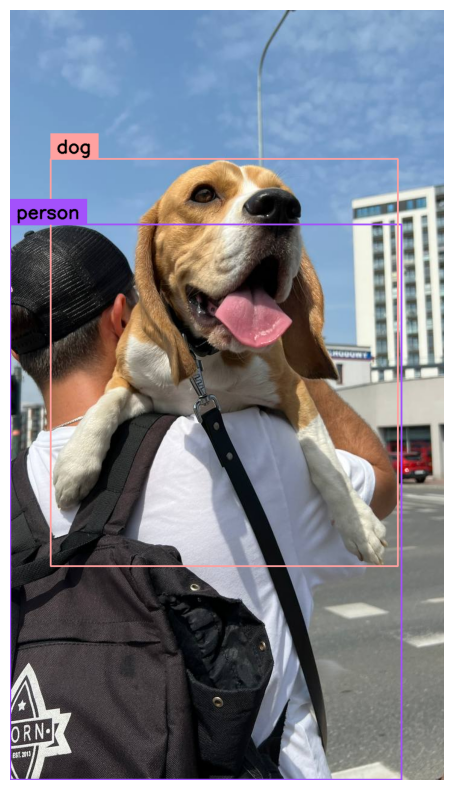

In [13]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## 调整置信度


**注意：**上面的结果没有检测到提示词中的很多类别。这是因为 Inference 中的默认置信度阈值被设置为 `0.5`。我们可以试着降低这个值，可以观察到在[COCO](https://github.com/cocodataset/cocodataset.github.io)数据集之外的查询中，YOLO-World 返回的置信度要低得多

In [14]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results)

在缺省情况下， `sv.LabelAnnotator` 只显示对象的名称。为了查看与每个检测相关联的置信度，我们必须定义自定义 `labels` 并将它们传递给 `sv.LabelAnnotator`。

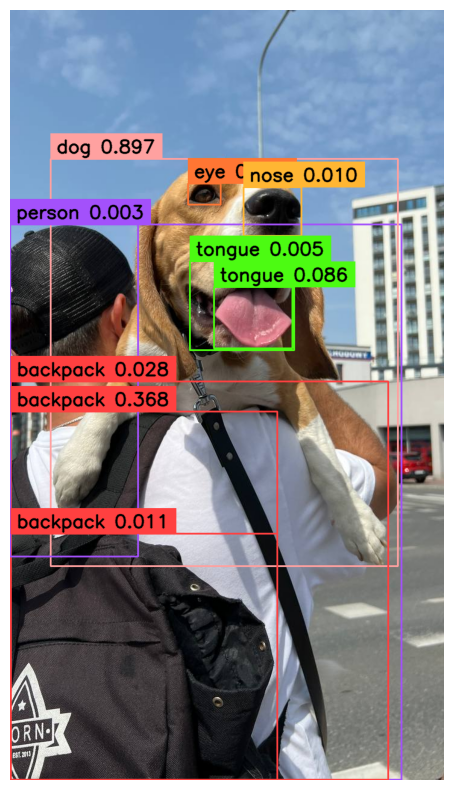

In [15]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## 利用非极大值抑制（NMS）消除双重检测


为了消除重复锚框，我们使用[非极大值抑制（NMS）](https://github.com/FrancescoSaverioZuppichini/non-max-suppression-in-pytorch)方法，使用并集度量的交叉点来评估检测重叠的程度。在超过阈值时，将锚框视为重复。然后从置信度最低的开始丢弃重复项，置信度范围为 `[0,1]` ，置信度越小表示 NMS 的限制越严格。






In [16]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.03)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

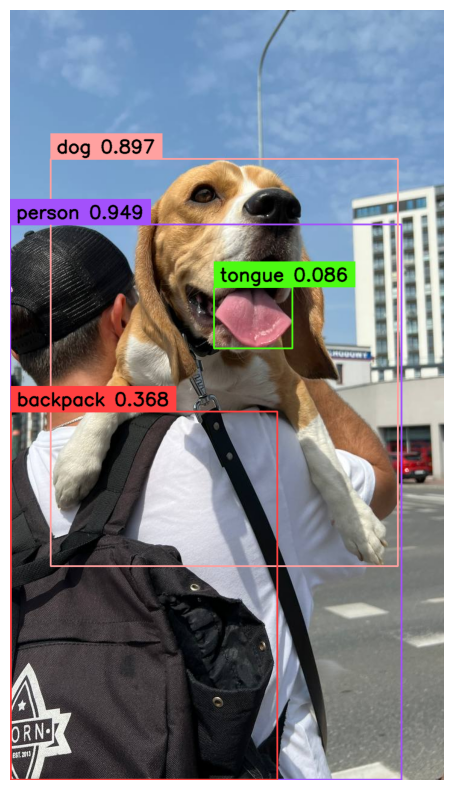

In [17]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## 视频处理

这里我借用了 Roboflow 的 [视频处理技术](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) 来迭代视频帧。首先为示例输入文件创建一个视频生成器，并在 Colab Notebook 上展示第一帧。

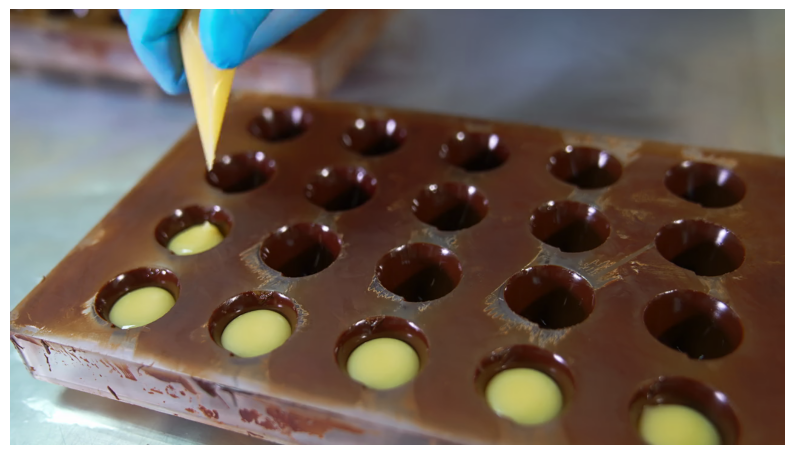

In [18]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)
sv.plot_image(frame, (10, 10))

更新类别列表，这次我们要找的是黄色填充物，其余执行检测、过滤和可视化的代码保持不变。

In [19]:
classes = ["yellow filling"]
model.set_classes(classes)

In [20]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

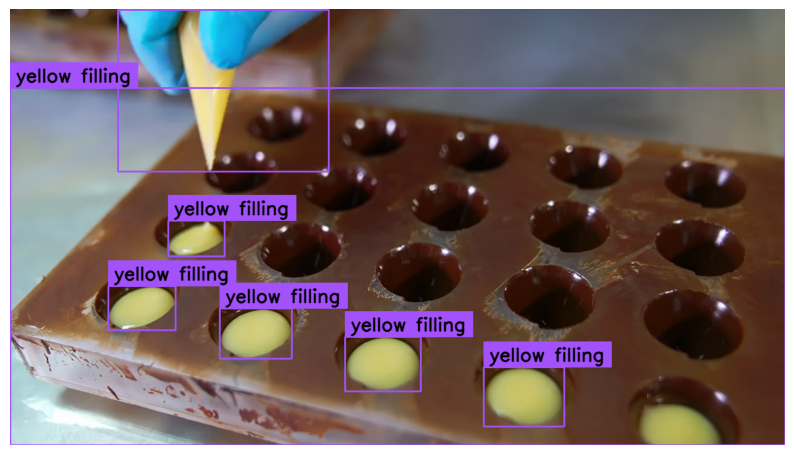

In [21]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## 区域过滤检测

我们的提示符允许我们定位所有需要填充的洞，但是也可能标记错误的洞。为了解决这个问题，我们将根据每个洞对于整个视频帧的相对面积来过滤检测。如果检测占用帧总面积的10%以上，则选择丢弃该检测。

我们可以使用[` VideoInfo.from_video_path `](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo)来了解视频的基本信息，如持续时间、分辨率或FPS。

In [22]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=442)

知道帧的分辨率可以让我们很容易地计算出它的总面积，以像素表示。

In [23]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

921600

通过使用[` sv. detection. area `](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) 属性，我们可以学习每个单独的边界框的面积。

In [24]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
detections.area

array([ 7.5408e+05,       92845,       11255,       12969,      9875.9,      8007.8,      5433.5])

把这两条信息结合起来，并为大于整个帧10%的检测构造一个滤波条件。

In [25]:
(detections.area / frame_area) < 0.10

array([False, False,  True,  True,  True,  True,  True])

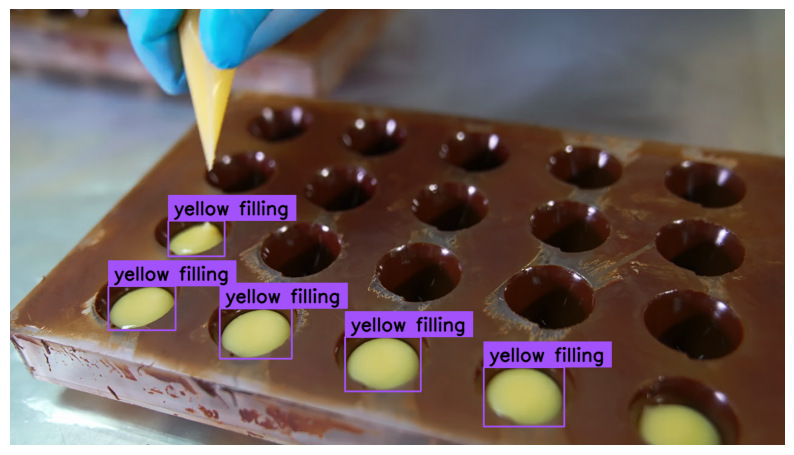

In [26]:
detections = detections[(detections.area / frame_area) < 0.10]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## 最终结果

最后处理整个视频。让我们感受下 YOLO-World 的处理速度。

In [27]:
TARGET_VIDEO_PATH = f"{HOME}/yellow-filling-output.mp4"

In [28]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

width, height = video_info.resolution_wh
frame_area = width * height
frame_area

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = model.infer(frame, confidence=0.002)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
        detections = detections[(detections.area / frame_area) < 0.10]

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        sink.write_frame(annotated_frame)

100%|██████████| 442/442 [00:24<00:00, 18.09it/s]
